In [1]:
# Setting up the environment
import folium
import json
import math
import numpy as np
import pandas as pd
import geopandas as gpd
from matplotlib import pyplot as plt
import timeit

# Part 0: Pre-process the datasets
In this part, we will pre-process the datasets, such as crime, commerical land use, population, street. 

In [3]:
# Crime dataset
# Read csv file
data= pd.read_csv("Crimes_-_2001_to_Present.csv")

# Number of primary crime
print(data['Primary Type'].count())

# Catalog of primary crime
print(data['Primary Type'].value_counts())

# Select rows based on the condition
options = ['THEFT', 'BATTERY', 'ASSAULT', 'ROBBERY'] 
rslt_df = data[data['Primary Type'].isin(options)] 

# Select columns from the rows
new = rslt_df[['Primary Type', 'Latitude', 'Longitude', 'Location']].copy()

# Remove rows with NA values
new = new.dropna()

# Save the new dataset
new.to_csv('new_crimedata_Chicago.csv', index=False)

7533119
THEFT                                1585804
BATTERY                              1381696
CRIMINAL DAMAGE                       858601
NARCOTICS                             742126
ASSAULT                               485919
OTHER OFFENSE                         468856
BURGLARY                              416782
MOTOR VEHICLE THEFT                   349047
DECEPTIVE PRACTICE                    327095
ROBBERY                               283143
CRIMINAL TRESPASS                     209853
WEAPONS VIOLATION                      97558
PROSTITUTION                           69560
OFFENSE INVOLVING CHILDREN             53505
PUBLIC PEACE VIOLATION                 51559
SEX OFFENSE                            29337
CRIM SEXUAL ASSAULT                    27754
INTERFERENCE WITH PUBLIC OFFICER       17923
LIQUOR LAW VIOLATION                   14679
GAMBLING                               14608
ARSON                                  12806
HOMICIDE                               11841
KI

In [4]:
# Commerical land use dataset
# Read geojson
gdf = gpd.read_file('osm_shops_restaurants.geojson')

# Keep only certain columns
gdf = gdf[['id', 'geometry', 'addr:street']]

# Remove rows with NA values
gdf = gdf.dropna()

# Show first rows in gdf
gdf.head()

,id,geometry,addr:street
1,relation/2814726,POINT (-87.69410 41.92517),North Talman Avenue
2,relation/2817831,POINT (-87.66430 41.94689),North Southport Avenue
3,relation/9765115,POINT (-87.69038 42.00202),North Western Avenue
4,way/28100638,POINT (-87.66769 41.92281),North Ashland Avenue
5,way/28293211,POINT (-87.63548 41.88853),Merchandise Mart Plaza


In [5]:
# Street dataset
# Read geojson
street = gpd.read_file('Street_Copy.geojson')

# Keep only certain columns
street = street[['geometry','street_nam','street_typ','class']]

# Save the new dataset
street.to_file("street_clean.geojson",driver="GeoJSON")

C:\Users\eugen\anaconda3\envs\myenv\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


In [6]:
# Boundaries dataset
# Read geojson
boundaries = gpd.read_file('boundaries.geojson')

# Reorganize the dataset
boundaries = boundaries[['zip','geometry','shape_area']]

# Save the new dataset
boundaries.to_file("boundaries_new.geojson",driver="GeoJSON")

C:\Users\eugen\anaconda3\envs\myenv\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


In [7]:
# Demographic dataset (merging them into boundaries)
# Load the boundaries dataset
with open('boundaries_new.geojson', encoding="utf-8") as json_file:
    data = json.load(json_file)
data = data['features']
data_zip = pd.DataFrame.from_dict(pd.json_normalize(data), orient='columns')

# Extract useful information (e.g. zip code, area, coordinates) from the dataset
data_zip = data_zip.drop(['type','geometry.type'],axis =1)
data_zip = data_zip.rename(columns={'properties.zip':'zip','properties.shape_area':'area','geometry.coordinates':'coordinates'})
data_zip.dropna(inplace=True)
data_zip.reset_index(inplace=True)
data_zip = data_zip.drop(['index'],axis =1)
data_zip['zip'] = data_zip['zip'].astype(int)
data_zip['area'] = data_zip['area'].astype(float)
data_copy = data_zip
data_copy

# Load the demographic dataset and extract useful information
demographic = pd.read_csv("Chicago_Population_Counts.csv")
demographic = demographic[['Geography','Population - Total']]
demographic = demographic.drop(range(0,61),axis=0)
demographic = demographic.rename(columns={'Geography':'zip','Population - Total':'population'})
demographic.dropna(inplace=True)
demographic.reset_index(inplace=True)
demographic = demographic.drop(['index'],axis =1)
demographic['zip'] = demographic['zip'].astype(int)
demographic['population'] = demographic['population'].astype(int)
demographic

# Merge and save the new dataset
data_demographic = pd.merge(data_copy,demographic,on='zip')
data_demographic.to_json('demographic.json')

# Part 1: Calculate interanction points of streets in Chicago
In this part, we will calculate the new variable 'street weight' that combines the road density and road class, which could be used to represent the condition of transportation. We mainly use the 'segment interaction' and 'spatial index'.

In [8]:
# Based on our demands, we will read and clean the dataset that we have pre-processed.
# Read the geojson and extract the properties that we need.
with open('street_clean.geojson', encoding="utf-8") as json_file:
    data = json.load(json_file)
data = data['features']
data_street = pd.DataFrame.from_dict(pd.json_normalize(data), orient='columns')
data_street = data_street.drop(['type','geometry.type','geometry'],axis =1)
data_street = data_street.rename(columns={'properties.street_nam':'name','properties.street_typ':'type',
                                          'properties.class':'class','geometry.coordinates':'geometry'})

# Check and rebuild the pre-processed street dataset
data_street.dropna(inplace=True)
data_street.reset_index(inplace=True)
data_street = data_street.drop(['index'],axis =1)
data_street['name'] = data_street['name'].astype(str)
data_street['type'] = data_street['type'].astype(str)
data_street['class'] = data_street['class'].astype(str)
data_copy = data_street
data_copy

,name,type,class,geometry
0,YALE,AVE,4,"[[[-87.63187018233509, 41.78080974758186], [-8..."
1,COTTAGE GROVE,AVE,2,"[[[-87.60548932047928, 41.76222964352745], [-8..."
2,CAMPBELL,AVE,4,"[[[-87.6838184819274, 41.69724384442973], [-87..."
3,SANGAMON,ST,4,"[[[-87.64584189298007, 41.69339840044404], [-8..."
4,118TH,ST,4,"[[[-87.67053671319235, 41.67975927489014], [-8..."
...,...,...,...,...
55193,BRAINARD,AVE,3,"[[[-87.55784956501411, 41.65791820995521], [-8..."
55194,MILWAUKEE,AVE,3,"[[[-87.73902939370839, 41.94834404748583], [-8..."
55195,KENNETH,AVE,4,"[[[-87.73879459600205, 41.94718195189966], [-8..."
55196,OHIO,ST,4,"[[[-87.74339277679763, 41.891415000932874], [-..."


In [9]:
# Due to the large area of Chicago, we decide to using bounding box to set up our own study area. 
# Range of study area (Boundaries of bounding box): x from -87.743 to -87.633, y from 41.736 to 41.816.
# k is the indexes of records that we want to delete.
k=[]
for i in data_copy.index:
    # Here, I delete the roads with types that we don't need, like the ramp of a expy/highway.
    if data_copy.loc[i,'type'] == 'XR' or data_copy.loc[i,'type'] == 'TER' or data_copy.loc[i,'type'] == 'ER':
        k.append(i)

    # If any vertice of a segment is outside of the boundary of bounding box, I would delete the whole segment.
    for j in range(0,len(data_copy.loc[i,'geometry'][0])):
        
        # Go through all coordinates of a record. Compare the coordinates with boundary.
        if (data_copy.loc[i,'geometry'][0][j][0] <= -87.743 or data_copy.loc[i,'geometry'][0][j][0] >= -87.633 or data_copy.loc[i,'geometry'][0][j][1] <= 41.736 or data_copy.loc[i,'geometry'][0][j][1] >= 41.816):
            k.append(i)

# list of k have a lot of duplicate values.
    # 1. Some records have the road type of XR, TER or ER, as well as have vertice(s) outside the bounding box.
    # 2. Some records have more than 1 vertices outside the bounding box, so the index was saved multiple times.
# So I have to deduplicate it.
deduplicated_k = list()
for item in k:
    if item not in deduplicated_k:
        deduplicated_k.append(item)
deduplicated_k

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 36,
 37,
 38,
 39,
 41,
 42,
 43,
 44,
 45,
 46,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 61,
 63,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 99,
 100,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 110,
 111,
 112,
 115,
 116,
 118,
 119,
 121,
 122,
 124,
 125,
 127,
 129,
 130,
 131,
 132,
 134,
 135,
 136,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 169,
 170,
 171,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 186,
 187,
 188,
 189,
 190,
 191,
 192,
 193,
 194,
 196,
 197,
 198,
 200,
 201,
 202,
 203,
 204,
 205,
 206,
 207,
 211,
 212,
 213,
 214,
 215,
 217

In [11]:
# Drop the records with index in list k.
data_new=data_copy.drop(deduplicated_k)
data_new.reset_index(inplace=True)
data_new = data_new.drop(['index'],axis =1)

# Still need some sentences to explain why we just make the class E or 9 as 5
for i in data_new.index:
    if data_new.loc[i,'class'] == 'E' or data_new.loc[i,'class'] == 9:
        data_new.at[i,'class']=5
data_new['class'] = data_new['class'].astype(int)
data_new

# Save the street dataset
data_new.to_csv('street.csv')
data_new.to_json('street.json')

In the data, if a segment intersected with another, it would be cut. So, for the segment intersection, we just need to consider, if the first point or the last point of a segment is shared by at lest two of other segments. If yes, it would be the crossing point. 

In [12]:
# Process the segment interaction
start = timeit.default_timer()
points = pd.DataFrame()

for i in data_new.index:
    # Only need to focus on starting and ending points here.
    for j in (0,len(data_new.loc[i,'geometry'][0])-1):
        # a is the point we use for comparison.
        # y is used to cound the segments that sharing the point.
        # z is the weight of a segment.
        # As I suppose crimes happen more near high-class roads, I use 6-(class value) to represent the weight.
        a = data_new.loc[i,'geometry'][0][j]
        y = 1
        z = 6-data_new.loc[i,'class']
        
        # Then I compare it with other points of segments with greater indexes.
        for k in range(i+1,max(data_new.index)+1):
            for l in (0,len(data_new.loc[k,'geometry'][0])-1):
                # If find a point that have the same coordinate, I would make y add 1, means I find another segment sharing this vertice.
                # I sum z up, which is the overall weight of points. If there are a lot of segments sharing the vertice, or the segments that sharing the vertice have larger weight, then the vertice would have a greater z.
                if (data_new.loc[k,'geometry'][0][l]) == a:
                    y = y+1
                    z = z+6-data_new.loc[k,'class']
        
        # If y is equal or greater than 3, it would be considered as crossing points. So I add the point to point dataframe.
        if y >= 3:
            data = [[a,z]]
            points = points.append(data,ignore_index = True)

            
stop = timeit.default_timer()
print('Time: ', stop - start) 

C:\Users\eugen\AppData\Local\Temp\ipykernel_96452\3097041537.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  points = points.append(data,ignore_index = True)


Time:  1757.0008193999997


In [13]:
# Built the new interaction points with their geometry and weight (means the combination of the road density and road class).
points = points.rename(columns={0:'geometry',1:'weight'})
points

,geometry,weight
0,"[-87.6540413652614, 41.76232762971525]",8
1,"[-87.65402050244748, 41.761416800680564]",10
2,"[-87.73178609194234, 41.744287454640435]",6
3,"[-87.73295978195388, 41.744909524324726]",6
4,"[-87.71298413347624, 41.771520084807925]",8
...,...,...
5980,"[-87.66195614621004, 41.755836444830884]",5
5981,"[-87.71311228988141, 41.79336771030571]",10
5982,"[-87.64263165885555, 41.78069141374427]",6
5983,"[-87.64376373665309, 41.776142196816636]",4


In [14]:
# We may have some duplicate points. For those vertices shared by more than 3 segments, it would be counted more than one time.
k=[]
for i in points.index:
    x=points.loc[i,'geometry'][0]
    y=points.loc[i,'geometry'][1]
    for j in range(i+1,max(points.index)+1):
        if (points.loc[j,'geometry'][0])==x and (points.loc[j,'geometry'][1])==y:
            k.append(j)

# I deduplicate in the same way as before.
deduplicated_k = list()
for item in k:
    if item not in deduplicated_k:
        deduplicated_k.append(item)
deduplicated_k

# Save the interaction points dataset
points_new=points.drop(deduplicated_k)
points_new.reset_index(inplace=True)
points_new = points_new.drop(['index'],axis =1)
points_new

,geometry,weight
0,"[-87.6540413652614, 41.76232762971525]",8
1,"[-87.65402050244748, 41.761416800680564]",10
2,"[-87.73178609194234, 41.744287454640435]",6
3,"[-87.73295978195388, 41.744909524324726]",6
4,"[-87.71298413347624, 41.771520084807925]",8
...,...,...
3639,"[-87.64266584225966, 41.77612081106971]",6
3640,"[-87.67469165929282, 41.81033317369515]",7
3641,"[-87.66195614621004, 41.755836444830884]",7
3642,"[-87.71311228988141, 41.79336771030571]",10


This step is simplification. If a point is too near to another, we have to delete the point. The algorithm to calculate distance with latitute and longitute comes from the first lecture of this course. The method is similar to the method of selecting segments inside of a bounding box. I use the k list as the indexes of records that I want to delete.

In [15]:
# The method and process is same as before. 
start = timeit.default_timer()

k=[]
for i in points_new.index:
    # I use if i not in k to avoid deleting the points that actually don't need to be deleted.
    if i not in k:
        for j in range(i+1,max(points_new.index)+1):
            if j not in k:
                d = 2 * 6371000 * np.arcsin(np.sqrt(np.sin((np.radians(points_new.loc[j,'geometry'][1]) - np.radians(points_new.loc[i,'geometry'][1]))/2)**2 + np.cos(np.radians(points_new.loc[i,'geometry'][1])) * np.cos(np.radians(points_new.loc[j,'geometry'][1])) * np.sin((np.radians(points_new.loc[j,'geometry'][0])-np.radians(points_new.loc[i,'geometry'][0]))/2)**2))
                if d < 100:
                    k.append(j)

stop = timeit.default_timer()
print('Time: ', stop - start)    

deduplicated_k = list()
for item in k:
    if item not in deduplicated_k:
        deduplicated_k.append(item)
deduplicated_k

# Sort out the final interaction points dataset
points_final = points_new.drop(deduplicated_k)
points_final.reset_index(inplace=True)
points_final = points_final.drop(['index'],axis =1)
points_final

# Save interaction points dataset
points_final.to_csv('points_final.csv')
points_final.to_json('points_final.json')

Time:  456.6334698999999


# Part 2: Calculate the number of crimes and commerical land use
In this part, we will calculate the number of crimes and commerical land use.We mainly use the 'points in circles' and 'spatial index'.

## 2.1 Crimes

In [16]:
# Read the crime dataset
data= pd.read_csv("new_crimedata_Chicago.csv")
crime_df = pd.DataFrame(data)

# Built the empty column
crime_df["Distance"] = 0

# Select the dataset using the bounding box (x from -87.743 to -87.633, y from 41.736 to 41.816)
crime_selected = data[(data['Longitude'] <= -87.43) &
          (data['Longitude'] >= -87.633) &
          (data['Latitude'] <= 41.816) &
          (data['Latitude'] >= 41.736)]

# Print the selected dataset
print(len(crime_selected))

# Save the selected crime
crime_selected.to_csv('crime_selected.csv')
crime_selected.to_json('crime_selected.json')

544285


In [17]:
# Read final interaction points
data= pd.read_csv("crime_selected.csv")
crime_selected_df = pd.DataFrame(data)

# Catalog of primary crime
print(crime_selected_df['Primary Type'].value_counts())

# Show the records of crime
crime_selected_df[:5]

# Built the geodataframe type of crime_selected_df
crime_selected_df1 = gpd.GeoDataFrame(
    crime_selected_df, geometry=gpd.points_from_xy(crime_selected_df['Longitude'], crime_selected_df['Latitude']))

# Quick check one point in intersection_points_df1
print(crime_selected_df1.loc[1,'geometry'].x)
print(crime_selected_df1.loc[1,'geometry'].y)

BATTERY    228707
THEFT      183179
ASSAULT     80988
ROBBERY     51411
Name: Primary Type, dtype: int64
-87.575997062
41.766247597


In [19]:
# Read final interaction points
points = pd.read_csv('points_final.csv')
intersection_points = pd.DataFrame(points)
intersection_points.rename(columns={'Unnamed: 0':'ID'}, inplace=True)

# Create two lists for the loop results to be placed
lat = []
lon = []

# For each row in a varible,
for row in intersection_points['geometry']:
    row = "".join(row)
    # Try to,
    try:
        # Split the row by comma and append
        # everything before the comma to lat
        lat.append(row.split(',')[0])
        # Split the row by comma and append
        # everything after the comma to lon
        lon.append(row.split(',')[1])
    # But if you get an error
    except:
        # append a missing value to lat
        lat.append(np.NaN)
        # append a missing value to lon
        lon.append(np.NaN)

# Create two new columns from lat and lon
intersection_points['Latitude'] = lat
intersection_points['Longitude'] = lon

intersection_points

,ID,geometry,weight,Latitude,Longitude
0,0,"[-87.6540413652614, 41.76232762971525]",8,[-87.6540413652614,41.76232762971525]
1,1,"[-87.65402050244748, 41.761416800680564]",10,[-87.65402050244748,41.761416800680564]
2,2,"[-87.73178609194234, 41.744287454640435]",6,[-87.73178609194234,41.744287454640435]
3,3,"[-87.73295978195388, 41.744909524324726]",6,[-87.73295978195388,41.744909524324726]
4,4,"[-87.71298413347624, 41.771520084807925]",8,[-87.71298413347624,41.771520084807925]
...,...,...,...,...,...
3022,3022,"[-87.65595139607863, 41.78868826260606]",8,[-87.65595139607863,41.78868826260606]
3023,3023,"[-87.64266584225966, 41.77612081106971]",6,[-87.64266584225966,41.77612081106971]
3024,3024,"[-87.66195614621004, 41.755836444830884]",7,[-87.66195614621004,41.755836444830884]
3025,3025,"[-87.71311228988141, 41.79336771030571]",10,[-87.71311228988141,41.79336771030571]


In [21]:
# Clean the two new columns
intersection_points['Latitude'] = [x.replace('[', '') for x in intersection_points['Latitude']]
intersection_points['Longitude'] = [x.replace(']', '') for x in intersection_points['Longitude']]

# Built the geodataframe type of intersection_points
intersection_points_df1 = gpd.GeoDataFrame(
    intersection_points, geometry=gpd.points_from_xy(intersection_points['Longitude'], intersection_points['Latitude']))

# Quick check one point in intersection_points_df1
print(intersection_points_df1.loc[1,'geometry'].x)
print(intersection_points_df1.loc[1,'geometry'].y)

41.761416800680564
-87.65402050244748


In [22]:
from numpy import sqrt, radians, arcsin, sin, cos

start = timeit.default_timer()

points = pd.DataFrame()

# Load the intersection points
for a in intersection_points_df1.index:
    # i is the interaction point we use for calculate.
    i = intersection_points_df1.loc[a,'geometry']
    # j is used to count the number of crime points that meets the requirements.
    j = 1

    # Load the crime points
    for b in crime_selected_df1.index:
        # c is the crime point we use for calculate.
        c = crime_selected_df1.loc[b,'geometry']
        # z is used to show the distance that is from the crime point to the interaction point.
        z = crime_selected_df1.loc[b,'Distance']
        # the formula of Haversine distance
        r = 6371000
        d = 2 * r * arcsin(sqrt(sin((radians(intersection_points_df1.loc[1,'geometry'].x) - radians(crime_selected_df1.loc[1,'geometry'].y))/2)**2 + cos(radians(intersection_points_df1.loc[1,'geometry'].x)) * cos(radians(crime_selected_df1.loc[1,'geometry'].y)) * sin((radians(intersection_points_df1.loc[1,'geometry'].y) - radians(crime_selected_df1.loc[1,'geometry'].x))/2)**2))
        
        # Count the number of crime and Calculate the distance
        if d <= 50:
            j = j + 1
            z = z + d
            
data = [[i,j]]
points = points.append(data,ignore_index = True)
    
stop = timeit.default_timer()
print('Time: ', stop - start) 

KeyboardInterrupt: 

## 2.2 Commerical Land Use

In [ ]:
# Filter points after the bounding box
corner1 = Point(-87.633, 41.736) 
corner2 = Point(-87.633, 41.816)
corner3 = Point(-87.43, 41.816)
corner4 = Point(-87.43, 41.736)

bbox_polygon = Polygon([corner1, corner2, corner3, corner4])
bbox_gdf = gpd.GeoDataFrame(gpd.GeoSeries(bbox_polygon), 
                            columns=['geometry'], crs='EPSG:4326')

commercials_selected = gpd.overlay(gdf, bbox_gdf, how='intersection')

# Save the selected commercials
commercials_selected.to_file('commercials_selected.geojson', driver="GeoJSON")

commercials_selected_gdf = gpd.read_file('commercials_selected.geojson')

# Read final interaction points
points = pd.read_csv('points_final.csv')
intersection_points = pd.DataFrame(points)
intersection_points.rename(columns={'Unnamed: 0':'ID'}, inplace=True)

# Create two lists for the loop results to be placed
lat = []
lon = []

# For each row in a varible,
for row in intersection_points['geometry']:
    row = "".join(row)
    # Try to,
    try:
        # Split the row by comma and append
        # everything before the comma to lat
        lat.append(row.split(',')[0])
        # Split the row by comma and append
        # everything after the comma to lon
        lon.append(row.split(',')[1])
    # But if you get an error
    except:
        # append a missing value to lat
        lat.append(np.NaN)
        # append a missing value to lon
        lon.append(np.NaN)

# Create two new columns from lat and lon
intersection_points['Latitude'] = lat
intersection_points['Longitude'] = lon

# Clean the two new columns
intersection_points['Latitude'] = list(set([x.replace('[', '') for x in intersection_points['Latitude']]))
intersection_points['Longitude'] = list(set([x.replace(']', '') for x in intersection_points['Longitude']]))

# Built the geodataframe type of intersection_points
intersection_points_df1 = gpd.GeoDataFrame(
    intersection_points, geometry=gpd.points_from_xy(intersection_points['Longitude'], intersection_points['Latitude']))

# Quick check one point in intersection_points_df1
print(intersection_points_df1.loc[1,'geometry'].x)
print(intersection_points_df1.loc[1,'geometry'].y)

In [ ]:
from numpy import sqrt, radians, arcsin, sin, cos

start = timeit.default_timer()

points = pd.DataFrame()

for a in tqdm(intersection_points_df1.index):
    # i is the interaction point we use for calculation.
    i = intersection_points_df1.loc[a,'geometry']
    # j is used to count the number of commercial points that meets the requirements.
    j = 1

    for b in commercials_selected_gdf.index:
        # c is the commercial point we use for calculation.
        c = commercials_selected_gdf.loc[b,'geometry']
        # z is used to show the distance that is from the commercal point to the interaction point.
        z = commercials_selected_gdf.loc[b,'Distance']
        # the formula of Haversine distance
        r = 6371000
        d = 2 * r * arcsin(sqrt(sin((radians(intersection_points_df1.loc[1,'geometry'].x) \
            - radians(commercials_selected_gdf.loc[1,'geometry'].y))/2)**2 \
            + cos(radians(intersection_points_df1.loc[1,'geometry'].x)) \
            * cos(radians(commercials_selected_gdf.loc[1,'geometry'].y)) \
            * sin((radians(intersection_points_df1.loc[1,'geometry'].y) \
            - radians(commercials_selected_gdf.loc[1,'geometry'].x))/2)**2))
        
        # Count the number of commercials and Calculate the distance
        if d <= 50:
            j = j + 1
            z = z + d
            
data = [[i,j]]
points = points.append(data,ignore_index = True)
    
stop = timeit.default_timer()
print('Time: ', stop - start) 

# Part 3 Calculate the number of population
In this part, we will calculate the population number of interanction points. We mainly use the 'points in polygon'.

In [ ]:
# Import the environment
import random
from shapely.geometry import Point, Polygon

# Import the module that I wrote
from geospatial import *

In [ ]:
# Read data
df_demog = pd.read_json("demographic.json")
df_points_orig = pd.read_json('points_weight_commercial.json')

In [ ]:
# Get color for each demographic region
np.random.seed(22)
colors = [[np.random.uniform(0, 1) for rep in range(3)] for region in range(df_demog.shape[0])]

# Convert coordinates of points to numbers
df_points = pd.DataFrame(df_points_orig)
df_points['geometry'] = df_points['geometry'].astype(str)

# Create two lists for the loop results to be placed
lat = []
lon = []

# For each row in a varible,
for row in df_points['geometry']:
    row = "".join(row)
    # Try to,
    try:
        # Split the row by comma and append
        # everything before the comma to lat
        lat.append(row.split(',')[0])
        # Split the row by comma and append
        # everything after the comma to lon
        lon.append(row.split(',')[1])
    # But if you get an error
    except:
        # append a missing value to lat
        lat.append(np.NaN)
        # append a missing value to lon
        lon.append(np.NaN)

# Create two new columns from lat and lon
df_points['Latitude'] = lat
df_points['Longitude'] = lon

# Clean the two new columns
df_points['Latitude'] = list(set([x.replace('[', '') for x in df_points['Latitude']]))
df_points['Longitude'] = list(set([x.replace(']', '') for x in df_points['Longitude']]))

In [ ]:
# Get polygons from coordinates of each demographic area
polygons = []

# Iterate over regions
for index, row in df_demog.iterrows():
    for i in range(len(row["coordinates"])):
        for j in range(len(row["coordinates"][i])):
            points_poly = np.array(row["coordinates"][i][j])
            polygons.append((index, Polygon(points_poly)))
    
# Plot polygons
plt.figure(figsize=(10, 10), dpi=80)
for index, poly in polygons:
    x,y = poly.exterior.xy
    plt.plot(x,y, color=colors[index])

In [ ]:
points = []

# Check which demographic area corresponds to each point
for point_idx, row in df_points.iterrows(): # Create 1000 random Points to test
    x = float(row['Latitude'])
    y = float(row['Longitude'])
    p = Point(x,y)
    
    # Find the corresponding polygon
    corr_poly_idx = -1
    for poly_idx, poly in polygons:
        if (poly.contains(p)):
            corr_poly_idx = poly_idx
            break;
            
    points.append((point_idx, p, corr_poly_idx))
            
# Plot points colored by their corresponding demographic region
# plt.figure(figsize=(10, 10), dpi=80)
points_colors = [colors[entry[2]] for entry in points]
plt.scatter(x = [entry[1].x for entry in points],
            y = [entry[1].y for entry in points], 
            c = points_colors)

In [ ]:
# Append demographic info to points
df_points['area'] = 0
df_points['population'] = 0

for point_idx, _, poly_idx in points:
    if poly_idx == -1:
        continue
        
    df_points.loc[point_idx, 'area'] = df_demog.loc[poly_idx, 'area']
    df_points.loc[point_idx, 'population'] = df_demog.loc[poly_idx, 'population']

# Calculation of population density
df_points = df_points.drop(['Latitude','Longitude'],axis =1)
df_points['pop/km2']=(df_points['population']/df_points['area'])*100000/0.0929
df_points

# Save final dataframe
df_points.to_json('points_all_x.json')

# Part 4: Correlation Analysis and Visualization

In this part, we will calculate the correlation coffincient of crime, commerical land use, population, and street weight.

In [23]:
# Define the function for correlation analysis
def corr(df,factors):
    corrmat = pd.DataFrame(columns = factors, index = factors)
    
    for i in factors:
        for j in factors:
            de = 0
            mo1 = 0
            mo2 = 0
            for k in df.index:
                de = de + (df[i][k]-np.mean(df[i]))*(df[j][k]-np.mean(df[j]))
                mo1 = mo1 + (df[i][k]-np.mean(df[i]))*(df[i][k]-np.mean(df[i]))
                mo2 = mo2 + (df[j][k]-np.mean(df[j]))*(df[j][k]-np.mean(df[j]))
            mo = np.sqrt(mo1)*np.sqrt(mo2)
            correlation = round(de/mo,4)
            corrmat[i][j]=correlation
            
    return corrmat

In [24]:
# Load the dataset and extract useful informations
points = pd.read_json("points_all_x.json")
crime = pd.read_csv("intersection_points_crime.csv")
points = pd.merge(points, crime, left_index = True, right_index = True)

points = points.drop(['Unnamed: 0','ID','geometry_y','weight_y','Latitude','Longitude','area','population'],axis =1)
points = points.rename(columns={'geometry_x':'geometry','weight_x':'weight'})

points.dropna(inplace=True)
points.reset_index(inplace=True)
points = points.drop(['index'],axis =1)

points

,geometry,weight,commercial,pop/km2,Crime
0,"[-87.6540413653, 41.7623276297]",8,0,364.488762,3669
1,"[-87.6540205024, 41.7614168007]",10,0,561.012857,4236
2,"[-87.7317860919, 41.7442874546]",6,0,310.413612,913
3,"[-87.732959782, 41.7449095243]",6,0,310.413612,2473
4,"[-87.7129841335, 41.7715200848]",8,0,310.413612,646
...,...,...,...,...,...
3016,"[-87.6559513961, 41.7886882626]",8,0,456.774667,1119
3017,"[-87.6426658423, 41.7761208111]",6,0,310.413612,912
3018,"[-87.6619561462, 41.7558364448]",7,0,310.413612,2778
3019,"[-87.7131122899, 41.793367710300004]",10,0,307.256734,4328


In [25]:
list = ['Crime','weight','commercial','pop/km2']
list

['Crime', 'weight', 'commercial', 'pop/km2']

In [26]:
corrmat = corr(points,list)
corrmat

,Crime,weight,commercial,pop/km2
Crime,1.0,0.0013,-0.0054,-0.0211
weight,0.0013,1.0,0.2647,0.0001
commercial,-0.0054,0.2647,1.0,-0.0257
pop/km2,-0.0211,0.0001,-0.0257,1.0


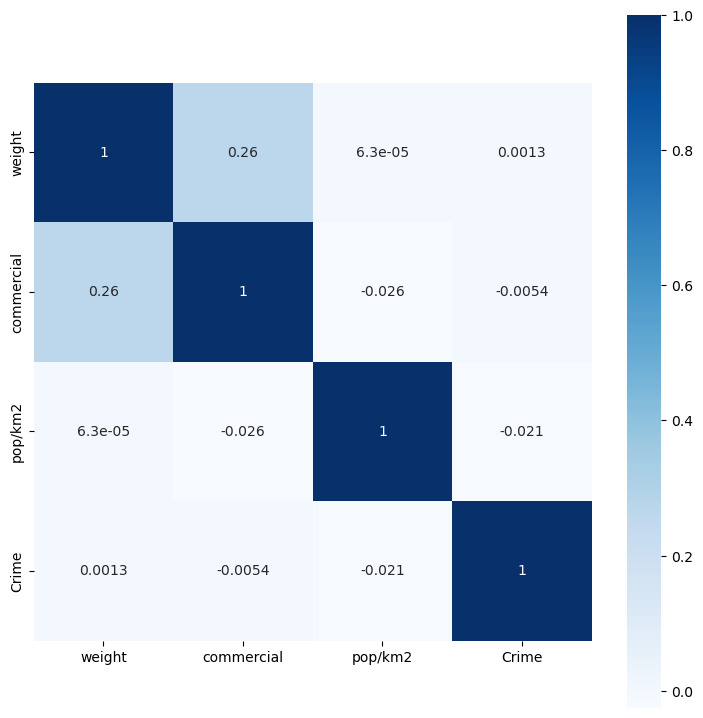

In [37]:
# Visualization
import seaborn as sns

a = points.corr()

plt.subplots(figsize=(9,9))
sns.heatmap(a, annot = True, vmax = 1, square = True, cmap = "Blues")
plt.show()